### Import modules

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.feature import hog
import skimage.io as io
from skimage.util import view_as_blocks
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
import pickle
import numpy as np
import warnings
import math
from skimage.feature import hog
from skimage import color
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fit encoders in order to map string labels to integers
# The fact that we are storing the scikit objects makes the encoding reproducible and consistent
# We do not need to fit each time, we store the fitted object and use its transform method when needed

label_encoder_specific = LabelEncoder().fit(pd.read_csv('dataset_cards/cards.csv')['labels'])  # Specific
label_encoder_category = LabelEncoder().fit(pd.read_csv('dataset_cards/cards.csv')['card type'])  # card type

In [4]:
class CardsDataset(Dataset):
    """
    A PyTorch Dataset class specifically aimed at digesting and retrieving the images of the cards, together with their
    labels, which are also reliably encoded.
    """

    def __init__(self, csv_path: str, root_dir: str, transform: str,
                 card_category: bool, label_encoder: LabelEncoder,
                 subset: str = 'train') -> None:
        """
        Initialization of the CardDataset class
        :param csv_path: The path of the csv where to retrieve the necessary information about the images of the cards.
        :param root_dir: The root directory for the dataset.
        :param transform: Option between Histogram of Gradients ('hog') or Histogram of colors ('rgb_hist').
        Pass None in order to avoid transformations (normalization at pixel level is the only operation performed).
        :param card_category: Whether the label refers to the card category or to the specific card itself.
        :param label_encoder: The scikit-learn LabelEncoder object necessary to map the string labels to integers.
        :param subset: Choose between train ('train'), test ('test') and validation ('valid') dataset.
        """
        total_cards = pd.read_csv(csv_path)
        try:
            self.cards_table = total_cards[total_cards['data set'] == subset]
        except KeyError:
            raise KeyError('There is no subset in the dataset with the queried label')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            self.cards_table['labels' if not card_category else 'card type'] = \
                label_encoder.transform(self.cards_table['labels']) if not card_category else \
                label_encoder.transform(self.cards_table['card type'])
        self.root_dir = root_dir
        self.transform = transform
        self.card_category = card_category

    def __len__(self):
        return len(self.cards_table)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        card_class = self.cards_table.iat[idx, 2] if not self.card_category else self.cards_table.iat[idx, 3]

        if self.transform == 'hog':
            representation = np.load(os.path.join(self.root_dir, 'hog',
                                                  self.cards_table.iat[idx, 1].split('.')[0] + '.npy'))
            representation = np.moveaxis(representation, 2, 0)
            
        elif self.transform == 'hog_2':
            img_path = os.path.join(self.root_dir, self.cards_table.iat[idx, 1])
            image = color.rgb2gray(io.imread(img_path))
            fd, hog_image = hog(image, orientations=6, pixels_per_cell=(12, 12),
                    cells_per_block=(1, 1), block_norm="L1", visualize=True, feature_vector = True)
            representation = fd
            
        elif self.transform is None or self.transform == 'rgb_hist':
            img_path = os.path.join(self.root_dir, self.cards_table.iat[idx, 1])
            image = io.imread(img_path)
            if self.transform == 'rgb_hist':
                representation, _ = np.histogramdd((np.reshape(image, (-1, 3))), bins=[np.linspace(0, 256, 6)] * 3)
                representation = (representation / representation.sum()).flatten()
            else:
                representation = np.moveaxis(image/255.0, 2, 0)

        else:
            raise ValueError(f'There is no transformation function for \'{self.transform}\'')

        return representation.astype(np.float32), card_class

### HOC

In [6]:
training_rgb = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                            transform='rgb_hist', card_category=False,
                            label_encoder=label_encoder_specific, subset='train')

X_rgb = np.array([i[0] for i in training_rgb])
y_rgb = np.array([i[1] for i in training_rgb])

In [7]:
valid_rgb = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                            transform='rgb_hist', card_category=False,
                            label_encoder=label_encoder_specific, subset='valid')

X_t_rgb = np.array([i[0] for i in valid_rgb])
y_t_rgb = np.array([i[1] for i in valid_rgb])

In [10]:
clf = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, max_iter = 300, solver="sag", verbose=0).fit(X_rgb, y_rgb)
print(f"11 bins 3D RGB","|",'Train set acc:', round(clf.score(X_rgb, y_rgb), 4), "|",'Validation set acc:',round(clf.score(X_t_rgb, y_t_rgb), 4))

11 bins 3D RGB | Train set acc: 0.0699 | Validation set acc: 0.0491


In [12]:
test_rgb = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                            transform='rgb_hist', card_category=False,
                            label_encoder=label_encoder_specific, subset='test')

X_t_rgb = np.array([i[0] for i in test_rgb])
y_t_rgb = np.array([i[1] for i in test_rgb])

In [13]:
clf = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, max_iter = 300, solver="sag", verbose=0).fit(X_rgb, y_rgb)
print(f"11 bins 3D RGB","|",'Train set acc:', round(clf.score(X_rgb, y_rgb), 4), "|",'Test set acc:',round(clf.score(X_t_rgb, y_t_rgb), 4))

11 bins 3D RGB | Train set acc: 0.0698 | Test set acc: 0.034


### HOG

### Training set

In [18]:
training_hog = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                            transform='hog_2', card_category=False,
                            label_encoder=label_encoder_specific, subset='train')

X_hog = np.array([i[0] for i in training_hog])
y_hog = np.array([i[1] for i in training_hog])

In [11]:
X_hog = np.load('X_hog.npy')
y_hog = np.load('y_hog.npy')

In [21]:
print(X_hog.shape)
print(y_hog.shape)

(7624, 1176)
(7624,)


### Validation set

In [12]:
validation_hog = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                            transform='hog_2', card_category=False,
                            label_encoder=label_encoder_specific, subset='valid')

X_hog_val = np.array([i[0] for i in validation_hog])
y_hog_val = np.array([i[1] for i in validation_hog])

In [14]:
print(X_hog_val.shape)
print(y_hog_val.shape)

(265, 1176)
(265,)


### Test set

In [16]:
test_hog = CardsDataset(csv_path=os.path.join('dataset_cards', 'cards.csv'), root_dir='dataset_cards',
                        transform='hog_2', card_category=False,
                        label_encoder=label_encoder_specific, subset='test')
    

X_t_hog = np.array([i[0] for i in test_hog])
y_t_hog = np.array([i[1] for i in test_hog])

In [13]:
X_t_hog = np.load('X_hog.npy')
y_t_hog = np.load('y_hog.npy')

In [17]:
print(X_t_hog.shape)
print(y_t_hog.shape)

(265, 1176)
(265,)


### Parameter tuning on validation set: model selection

#### Regularization parameter C

* #### C=0.1

In [22]:
clf = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, max_iter = 300, solver="sag", verbose=0, C=0.1).fit(X_hog, y_hog)
print(f"C=0.1","|",'Training set acc:', round(clf.score(X_hog, y_hog), 4), "|",'Validation set acc:',round(clf.score(X_hog_val, y_hog_val), 4))

C=0.1 | Training set acc: 0.8465 | Validation set acc: 0.6868


* #### C=1 (default value), C=10, C=100

In [24]:
for c in [1,10,100]:
    clf = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, max_iter = 300, solver="sag", verbose=0, C=c).fit(X_hog, y_hog)
    print(f"C={c}","|",'Training set acc:', round(clf.score(X_hog, y_hog), 4), "|",'Validation set acc:',round(clf.score(X_hog_val, y_hog_val), 4))

C=1 | Training set acc: 0.9963 | Validation set acc: 0.6792
C=10 | Training set acc: 0.9999 | Validation set acc: 0.6755
C=100 | Training set acc: 0.9999 | Validation set acc: 0.6792


### Best model performance

In [25]:
clf = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, max_iter = 300, solver="sag", verbose=0, C=0.1).fit(X_hog, y_hog)

In [26]:
# RISULTATO MIGLIORE
print('Accuracy on test set:', round(clf.score(X_t_hog, y_t_hog), 4))

Accuracy on test set: 0.6792


#### Confusion Matrix

In [ ]:
#y_pred = np.load('y_pred.npy') ### The predicted values

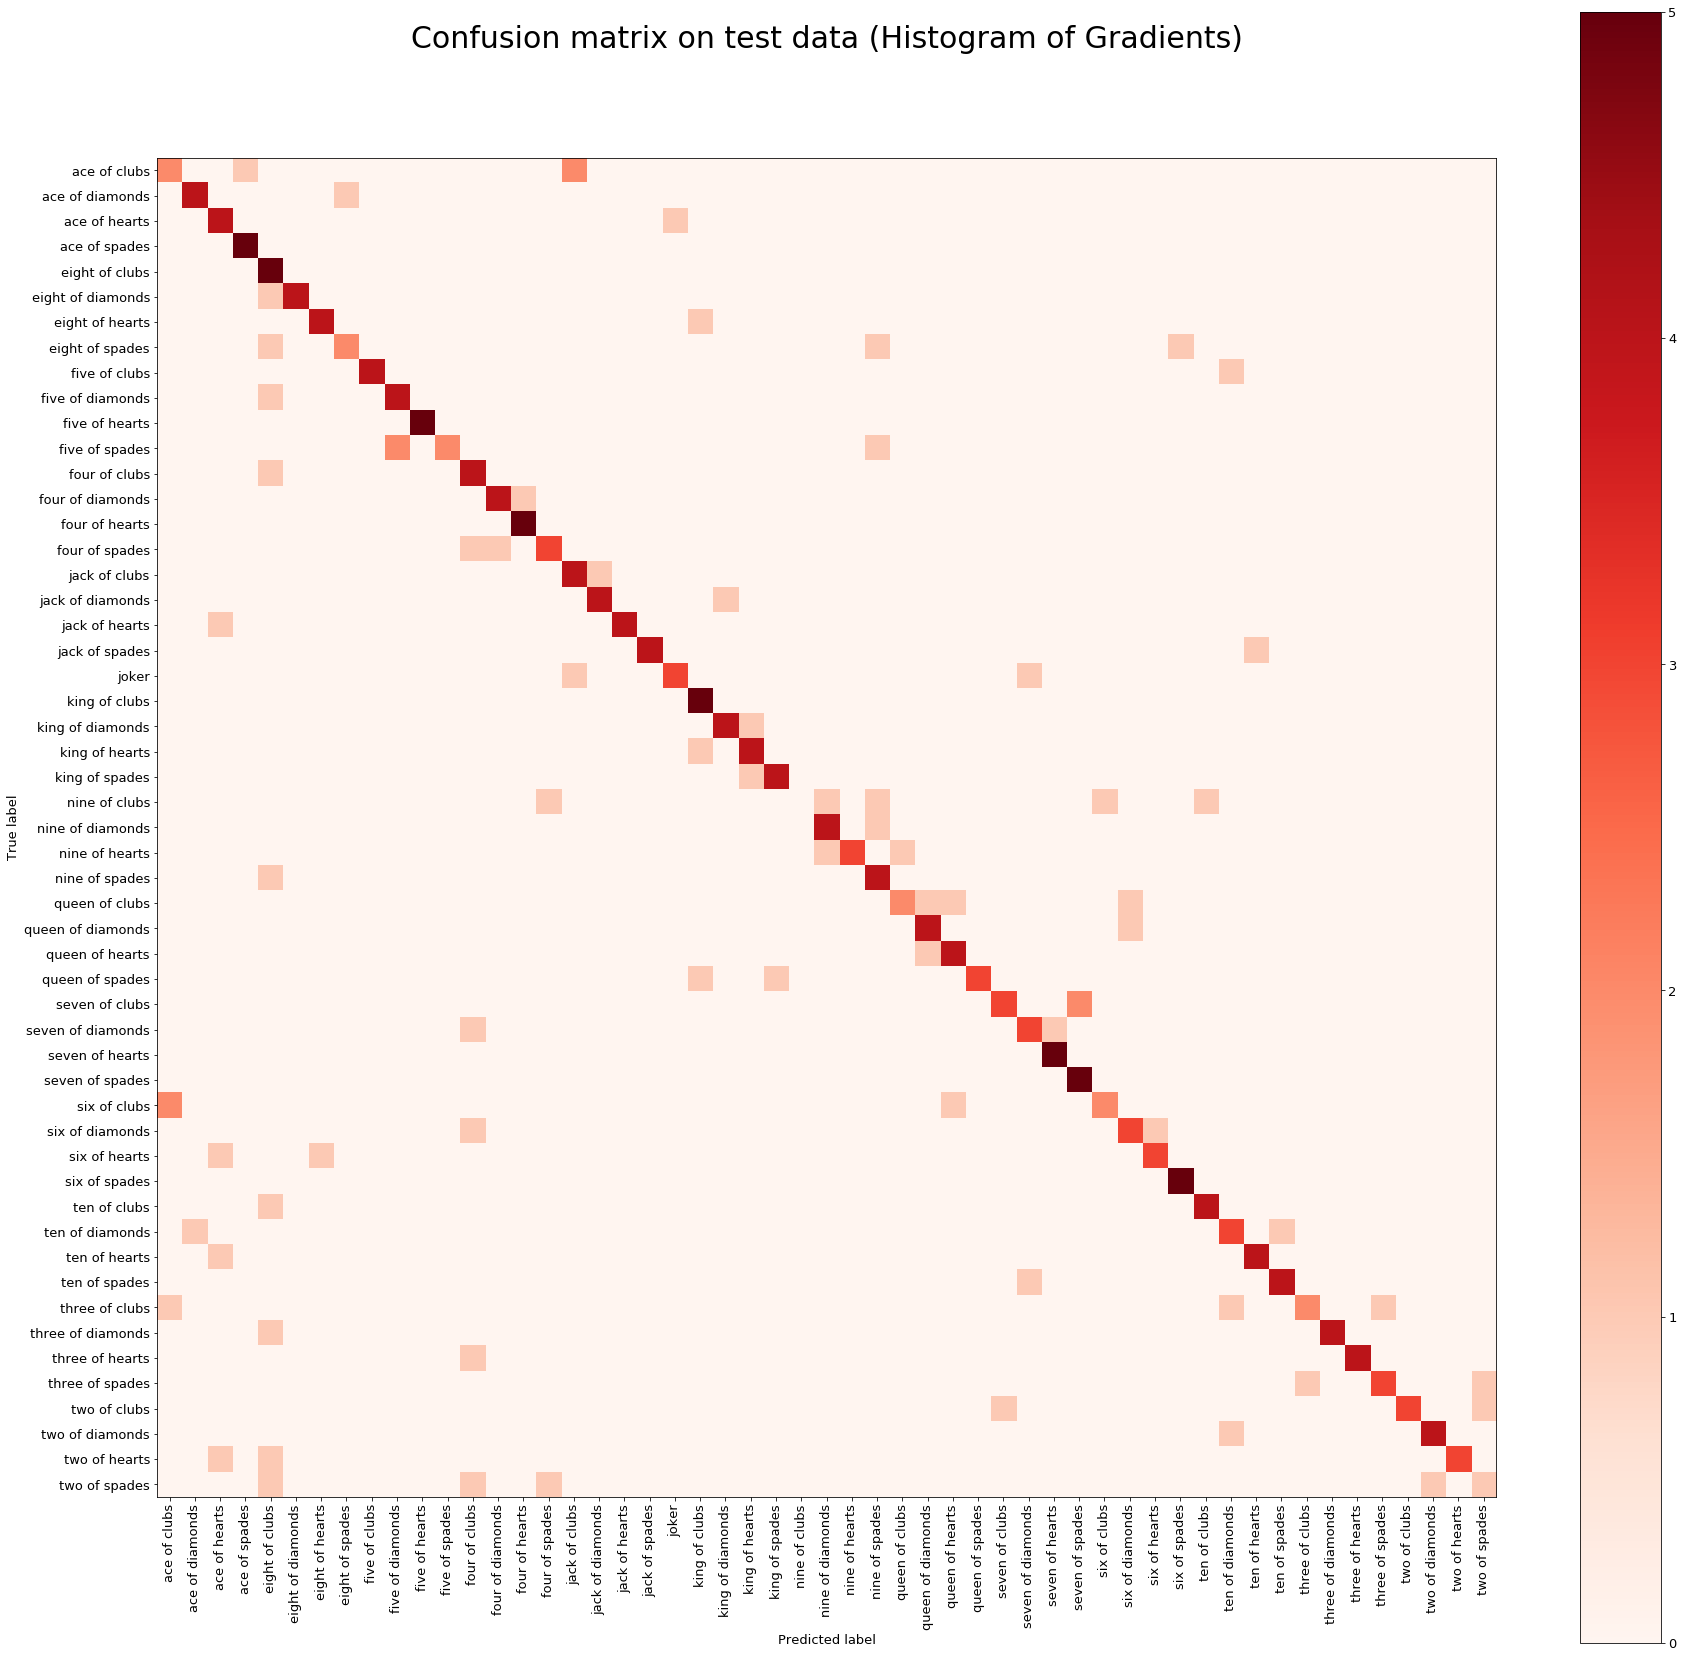

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams.update({'font.size': 13, 'figure.figsize': (30, 30)})

ConfusionMatrixDisplay.from_predictions(label_encoder_specific.classes_[y_t_hog],
                                        label_encoder_specific.classes_[y_pred],
                                        cmap = 'Reds', include_values = False,
                                        xticks_rotation = 'vertical')

plt.title('Confusion matrix on test data (Histogram of Gradients)', fontdict = {'size':30}, pad=110)

plt.savefig('conf_mat_hog.png')

### HOC + HOG

In [65]:
# training set
X_rgb_hog = np.hstack((X_rgb, X_hog))
y_rgb_hog = y_hog

# test set
X_rgb_hog_t = np.hstack((X_t_rgb, X_t_hog))
y_rgb_hog_t = y_t_hog

In [68]:
clf_rgb_hog = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, solver="sag", verbose=1).fit(X_rgb_hog, y_rgb_hog)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 139 seconds


C:\Users\iadig\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.3min finished


In [70]:
# training set accuracy
print('Accuracy:', round(clf_rgb_hog.score(X_rgb_hog, y_rgb_hog), 4))

Accuracy: 0.9178


In [69]:
# test set accuracy
print('Accuracy:', round(clf_rgb_hog.score(X_rgb_hog_t, y_rgb_hog_t), 4))

Accuracy: 0.6491


### Try normalizing X_rgb_hog and X_rgb_hog_t

In [80]:
scaler = MinMaxScaler()
scaler.fit(X_rgb_hog)
scaled_X = scaler.transform(X_rgb_hog)
scaler.fit(X_rgb_hog_t)
scaled_X_t = scaler.transform(X_rgb_hog_t)

In [82]:
clf_rgb_hog_scaled = LogisticRegression(multi_class="multinomial", n_jobs=os.cpu_count()//2, solver="sag", verbose=1).fit(scaled_X, y_rgb_hog)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 139 seconds


C:\Users\iadig\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.3min finished


In [84]:
# training set accuracy
print('Accuracy:', round(clf_rgb_hog_scaled.score(scaled_X_t, y_rgb_hog_t), 4))

Accuracy: 0.6113
